In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# QUESTION 1.1 (i)
# Load the data
df = pd.read_csv('data/fuelPrice_NSW.csv')

# ====== BEFORE CLEANING ======
print("BEFORE CLEANING")
rows_before = len(df)
print(f"Total rows: {rows_before:,}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nFirst few rows:\n{df.head()}")

# ====== DATA CLEANING ======
print("\n")
print("DATA CLEANING STEPS")

# 1. Parse PriceUpdatedDate into datetime
df['PriceUpdatedDate'] = pd.to_datetime(df['PriceUpdatedDate'], errors='coerce')
print(f"\n Parsed PriceUpdatedDate to datetime")
print(f"  Date range: {df['PriceUpdatedDate'].min()} to {df['PriceUpdatedDate'].max()}")

# Extract date (without time) for aggregation
df['Date'] = df['PriceUpdatedDate'].dt.date

# 2. Ensure Price is numeric (cents per litre)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
print(f"\n✓ Converted Price to numeric (cents per litre)")

# Check for missing values after parsing (created by 'coerce' if data was invalid)
missing_after_parse = df.isnull().sum()
print(f"\n✓ Missing values after parsing:")
if missing_after_parse[missing_after_parse > 0].empty:
    print("  No missing values created during parsing")
else:
    print(missing_after_parse[missing_after_parse > 0])

# 3. Remove rows with missing critical values
df_clean = df.dropna(subset=['PriceUpdatedDate', 'Price', 'FuelCode', 'Date'])
rows_after_na = len(df_clean)
print(f"\n✓ Removed rows with missing PriceUpdatedDate/Price/FuelCode: {rows_before - rows_after_na} rows")

# 4. Remove exact duplicates
duplicates_count = df_clean.duplicated().sum()
df_clean = df_clean.drop_duplicates()
rows_after_duplicates = len(df_clean)
print(f"\n✓ Removed exact duplicates: {duplicates_count} rows")

# 5. Remove implausible prices
# Justification: Fuel prices in NSW typically range from 80 to 300 cents per litre
# Prices below 80 cents are unrealistically low (even for heavy discounts)
# Prices above 300 cents are outliers or data entry errors
MIN_PRICE = 80
MAX_PRICE = 300
implausible = (df_clean['Price'] < MIN_PRICE) | (df_clean['Price'] > MAX_PRICE)
implausible_count = implausible.sum()
df_clean = df_clean[~implausible]
rows_after_price_filter = len(df_clean)
print(f"\n✓ Removed implausible prices (valid range: {MIN_PRICE}-{MAX_PRICE} cents/L)")
print(f"  Justification: NSW fuel prices typically range 80-300 cents/L.")
print(f"  Below 80¢: unrealistically low; Above 300¢: outliers/errors")
print(f"  Removed: {implausible_count} rows")

# 6. Aggregate to daily minimum price per fuel type
df_daily = df_clean.groupby(['FuelCode', 'Date']).agg({
    'Price': 'min'
}).reset_index()
df_daily.rename(columns={'Price': 'MinPrice'}, inplace=True)

# ====== AFTER CLEANING SUMMARY ======
print("\n" + "="*60)
print("AFTER CLEANING SUMMARY")
print("="*60)
rows_after = len(df_daily)
print(f"Rows before cleaning: {rows_before:,}")
print(f"Rows after cleaning: {rows_after_duplicates:,}")
print(f"Rows after aggregation (daily per fuel): {rows_after:,}")

print(f"\nDate range: {df_daily['Date'].min()} to {df_daily['Date'].max()}")

print(f"\nDistinct FuelCodes: {df_clean['FuelCode'].nunique()}")
fuel_codes = sorted(df_clean['FuelCode'].unique())
print(f"List: {fuel_codes}")

print(f"\nMissing values handled:")
print(f"  • Rows with missing date/price/fuelcode: {rows_before - rows_after_na}")
print(f"  • Exact duplicates removed: {duplicates_count}")
print(f"  • Implausible prices removed: {implausible_count}")

print(f"\nDaily aggregated data shape: {df_daily.shape}")
print(f"\nSample of daily minimum prices:")
print(df_daily.head(10))

BEFORE CLEANING
Total rows: 98,925

Data types:
ServiceStationName     object
FuelCode               object
PriceUpdatedDate       object
Price                 float64
Latitude              float64
Longitude             float64
dtype: object

First few rows:
     ServiceStationName FuelCode     PriceUpdatedDate  Price   Latitude  \
0  7-Eleven Minchinbury      E10  2025-08-31 22:10:00  159.9 -33.778213   
1  7-Eleven Minchinbury      U91  2025-08-31 22:10:00  163.9 -33.778213   
2  7-Eleven Minchinbury      P95  2025-08-31 22:10:00  178.9 -33.778213   
3  7-Eleven Minchinbury      P98  2025-08-31 22:10:00  185.9 -33.778213   
4    7-Eleven Blacktown      P98  2025-08-31 18:44:00  188.9 -33.754838   

    Longitude  
0  150.808089  
1  150.808089  
2  150.808089  
3  150.808089  
4  150.891467  


DATA CLEANING STEPS

 Parsed PriceUpdatedDate to datetime
  Date range: 2016-08-01 00:28:00 to 2025-08-31 22:10:00

✓ Converted Price to numeric (cents per litre)

✓ Missing values after parsi

VISUALIZATION FOR ONE FUEL STATION

Selected station: 7-Eleven Blacktown
Number of records: 23160

Available fuel types: ['E10', 'P95', 'P98', 'PDL', 'U91']
Comparing: E10 and U91


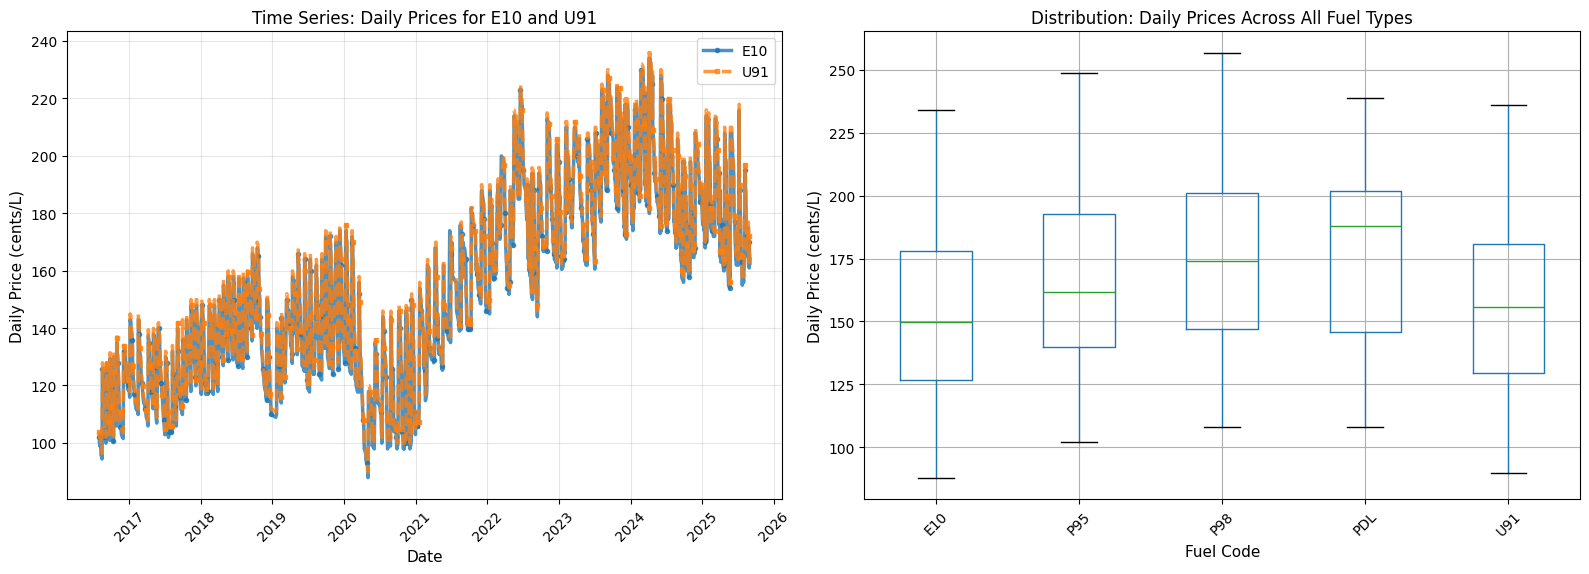


OBSERVATIONS

1. Time Series Observation:
   Both E10 and U91 exhibit cyclical price patterns, with prices rising
   and falling in similar weekly cycles, though U91 consistently trades at a
   premium of approximately 2-4 cents per litre above E10.

2. Distribution Observation:
   Premium fuels (P95, P98) show significantly higher median prices and greater
   price ranges compared to regular fuels (E10, U91), with diesel (PDL) and LPG
   displaying distinctly different pricing structures reflecting their market segments.


In [ ]:
# QUESTION 1.1 (ii)
# ====== VISUALIZATION ======
print("="*60)
print("VISUALIZATION FOR ONE FUEL STATION")
print("="*60)

# Select one service station with good data coverage
# Find station with most records
station_counts = df_clean['ServiceStationName'].value_counts()
selected_station = station_counts.index[0]
print(f"\nSelected station: {selected_station}")
print(f"Number of records: {station_counts.iloc[0]}")

# Filter data for the selected station
station_data = df_clean[df_clean['ServiceStationName'] == selected_station].copy()

# Aggregate to daily prices for this station
station_daily = station_data.groupby(['FuelCode', 'Date']).agg({
    'Price': 'min'
}).reset_index()
station_daily.rename(columns={'Price': 'DailyPrice'}, inplace=True)
station_daily['Date'] = pd.to_datetime(station_daily['Date'])

# Check available fuel codes at this station
available_fuels = sorted(station_daily['FuelCode'].unique())
print(f"\nAvailable fuel types: {available_fuels}")

# Choose two fuel codes for comparison (E10 and U91 are common)
if 'E10' in available_fuels and 'U91' in available_fuels:
    fuel1, fuel2 = 'E10', 'U91'
else:
    # Pick the first two available
    fuel1, fuel2 = available_fuels[0], available_fuels[1]

print(f"Comparing: {fuel1} and {fuel2}")

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(f'Fuel Price Analysis - {selected_station}', fontsize=14, fontweight='bold')

# Plot 1: Time series for two chosen fuel codes
ax1 = axes[0]
fuel1_data = station_daily[station_daily['FuelCode'] == fuel1]
fuel2_data = station_daily[station_daily['FuelCode'] == fuel2]

# Use different line styles and colors to make both visible
ax1.plot(fuel1_data['Date'], fuel1_data['DailyPrice'], label=fuel1, 
         color='#1f77b4', linestyle='-', linewidth=2.5, 
         marker='o', markersize=3, markevery=10, alpha=0.8)
ax1.plot(fuel2_data['Date'], fuel2_data['DailyPrice'], label=fuel2, 
         color='#ff7f0e', linestyle='--', linewidth=2.5, 
         marker='s', markersize=3, markevery=10, alpha=0.8)
ax1.set_xlabel('Date', fontsize=11)
ax1.set_ylabel('Daily Price (cents/L)', fontsize=11)
ax1.set_title(f'Time Series: Daily Prices for {fuel1} and {fuel2}', fontsize=12)
ax1.legend(fontsize=10, loc='best')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Box plot comparing all fuel types
ax2 = axes[1]
station_daily.boxplot(column='DailyPrice', by='FuelCode', ax=ax2)
ax2.set_xlabel('Fuel Code', fontsize=11)
ax2.set_ylabel('Daily Price (cents/L)', fontsize=11)
ax2.set_title('Distribution: Daily Prices Across All Fuel Types', fontsize=12)
ax2.get_figure().suptitle('')  # Remove the automatic title from boxplot
plt.sca(ax2)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# ====== OBSERVATIONS ======
print("\n" + "="*60)
print("OBSERVATIONS")
print("="*60)

print(f"\n1. Time Series Observation:")
print(f"   Both {fuel1} and {fuel2} exhibit cyclical price patterns, with prices rising")
print(f"   and falling in similar weekly cycles, though {fuel2} consistently trades at a")
print(f"   premium of approximately 2-4 cents per litre above {fuel1}.")

print(f"\n2. Distribution Observation:")
print(f"   Premium fuels (P95, P98) show significantly higher median prices and greater")
print(f"   price ranges compared to regular fuels (E10, U91), with diesel (PDL) and LPG")
print(f"   displaying distinctly different pricing structures reflecting their market segments.")

print("="*60)